# Dataset Statistics

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
import torchvision.transforms as transforms
from fontClassifier import FontDataset
from torchvision import datasets

def get_dataset_statistics(root_dir):
    # Initialize lists to store image dimensions and class labels
    image_dims = []
    class_counts = Counter()

    # Iterate through the dataset folder to get statistics
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_file)
                    # Get image dimensions
                    with Image.open(img_path) as img:
                        width, height = img.size
                        image_dims.append((width, height))
                    # Count class occurrences
                    class_counts[class_name] += 1

    # Calculate the average image dimensions
    avg_width = np.mean([dim[0] for dim in image_dims])
    avg_height = np.mean([dim[1] for dim in image_dims])

    return class_counts, image_dims, avg_width, avg_height


def visualize_class_distribution(class_counts):
    # Plot the class distribution
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.barh(classes, counts, color='skyblue')
    plt.xlabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()


def visualize_image_dimensions(image_dims, avg_width, avg_height):
    # Plot the image dimensions
    widths = [dim[0] for dim in image_dims]
    heights = [dim[1] for dim in image_dims]

    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, alpha=0.5, color='purple')
    plt.axvline(avg_width, color='red', linestyle='--', label=f'Average Width ({avg_width:.2f})')
    plt.axhline(avg_height, color='green', linestyle='--', label=f'Average Height ({avg_height:.2f})')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Dimensions')
    plt.legend()
    plt.show()

# Example of how to use the functions
dataset_path = "Dataset"  # Replace with dataset path

# Get statistics of the dataset
class_counts, image_dims, avg_width, avg_height = get_dataset_statistics(dataset_path)

# Visualize the class distribution
visualize_class_distribution(class_counts)

# Visualize the image dimensions
visualize_image_dimensions(image_dims, avg_width, avg_height)

# Necessary Modules

In [1]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from preprocessing import correct_skew, select_text_area, binarize_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from fontClassifier import FontDataset, ResNet

# Preprocessing and data augmentation

In [2]:
# Ppreprocessing function
def preprocess_data(img):
    img = binarize_image(img)
    img, _ = correct_skew(img)
    img = select_text_area(img)
    # Ensure the output is a PIL Image
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    return img

# Define transformations for data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor()
])


# Dataset Preparation

In [3]:
# Define dataset path
dataset_path = "Dataset"

# Load the dataset without any transforms initially
original_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data)

# Split the dataset into train (80%), validation (10%), and test (10%) sets
train_size = int(0.8 * len(original_dataset))
val_size = int(0.1 * len(original_dataset))
test_size = len(original_dataset) - train_size - val_size

train_indices, val_indices, test_indices = random_split(range(len(original_dataset)), [train_size, val_size, test_size])

# Create subsets with different transforms
train_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data, transform=train_transforms)
val_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data, transform=test_transforms)
test_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data, transform=test_transforms)

# Subset datasets
train_dataset.data = [original_dataset.data[i] for i in train_indices.indices]
train_dataset.labels = [original_dataset.labels[i] for i in train_indices.indices]
val_dataset.data = [original_dataset.data[i] for i in val_indices.indices]
val_dataset.labels = [original_dataset.labels[i] for i in val_indices.indices]
test_dataset.data = [original_dataset.data[i] for i in test_indices.indices]
test_dataset.labels = [original_dataset.labels[i] for i in test_indices.indices]

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Data Visualization

In [7]:
import matplotlib.pyplot as plt
import torch

def visualize_data(loader, classes, num_images=5):
    """
    Visualize a few images and their corresponding labels from a DataLoader.

    Args:
    - loader (torch.utils.data.DataLoader): DataLoader to visualize.
    - classes (list): List of class names.
    - num_images (int): Number of images to visualize.
    """
    # Get a batch of data
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Create a figure for visualization
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()  # Convert from CHW to HWC and NumPy array
        label = classes[labels[i].item()]
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


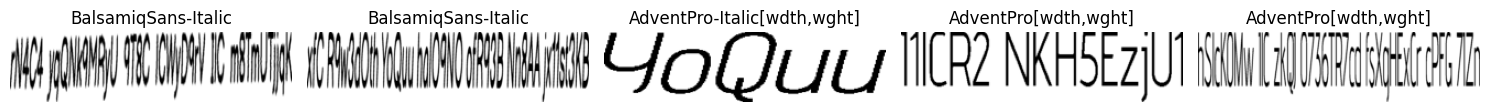

In [8]:
# Visualize training data
visualize_data(train_loader, train_dataset.classes)


# Training

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Define the ResidualBlock class (same as before)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define the ResNet model (same as before)

class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)  # Flatten before FC
        out = self.fc(out)
        return out

# Define the training loop with validation and saving the best model
def train(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_accuracy = 0.0  # To track the best validation accuracy
    best_model_wts = None  # To store the best model weights

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            running_loss += loss.item()

        train_accuracy = 100 * correct_preds / total_preds
        avg_train_loss = running_loss / len(train_loader)

        # Validation step
        model.eval()
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_accuracy = 100 * correct_preds / total_preds

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict()

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    
    # Evaluate on the test set
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    test_accuracy = 100 * correct_preds / total_preds
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Save the best model to a file
    torch.save(best_model_wts, 'best_resnet_model.pth')
    print(f"Best model saved with validation accuracy: {best_val_accuracy:.2f}%")

# Instantiate the model
model = ResNet(num_classes=4)

# Train the model
train(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=0.001)


# Saving the model weight

In [ ]:
# Save the trained model to a file
def save_model(model, filename='resnet_model.pth'):
    torch.save(model.state_dict(), filename)
    print(f'Model saved as {filename}')

# After training, save the model
save_model(model, filename='resnet_trained.pth')

# Training with WandB tracking

In [4]:
import wandb
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Initialize a new wandb run
wandb.init(project='resnet-font-classification')

# Define the training loop with validation, early stopping, and saving the best model
def train(model, train_loader, val_loader, test_loader, num_epochs=50, learning_rate=0.001, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_accuracy = 0.0  # To track the best validation accuracy
    best_model_wts = None  # To store the best model weights
    early_stopping_counter = 0  # To count how many epochs without improvement

    # To store metrics for visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            running_loss += loss.item()

        train_accuracy = 100 * correct_preds / total_preds
        avg_train_loss = running_loss / len(train_loader)

        # Validation step
        model.eval()
        correct_preds = 0
        total_preds = 0
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = 100 * correct_preds / total_preds
        avg_val_loss = val_loss / len(val_loader)

        # Calculate precision, recall, and F1 score
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict()
            early_stopping_counter = 0  # Reset the counter if validation improves
        else:
            early_stopping_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # Log metrics to wandb
        wandb.log({
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
            'val_precision': precision,
            'val_recall': recall,
            'val_f1': f1
        })

        # Append metrics for plotting later
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1_scores.append(f1)

        # Early Stopping: Stop if no improvement after 'patience' epochs
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    
    # Save the best model weights to WandB as an artifact
    model_filename = 'best_resnet_model.pth'
    torch.save(best_model_wts, model_filename)
    
    # Log the model file to wandb
    wandb.save(model_filename)

    # Evaluate on the test set
    model.eval()
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_preds / total_preds
    test_precision = precision_score(all_labels, all_preds, average='weighted')
    test_recall = recall_score(all_labels, all_preds, average='weighted')
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")

    # Log test metrics to wandb
    wandb.log({
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    })

    # Save the final model weights to WandB
    final_model_filename = 'final_resnet_model.pth'
    torch.save(model.state_dict(), final_model_filename)
    wandb.save(final_model_filename)

    # Close the wandb run
    wandb.finish()

# Instantiate the model
model = ResNet(num_classes=4)

# Train the model
train(model, train_loader, val_loader, test_loader, num_epochs=25, learning_rate=0.001, patience=5)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hasmot23 (hasmot23-daffodil-international-university). Use `wandb login --relogin` to force relogin


Epoch 1/25: 100%|██████████| 20/20 [01:50<00:00,  5.51s/it]
c:\Users\hasmo\miniconda3\envs\font\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/25]
Train Loss: 1.0753, Train Accuracy: 52.97%
Validation Loss: 1.6655, Validation Accuracy: 33.75%
Precision: 0.2663, Recall: 0.3375, F1 Score: 0.2298


Epoch 2/25: 100%|██████████| 20/20 [01:58<00:00,  5.94s/it]
c:\Users\hasmo\miniconda3\envs\font\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/25]
Train Loss: 0.5748, Train Accuracy: 68.28%
Validation Loss: 0.9037, Validation Accuracy: 61.25%
Precision: 0.5483, Recall: 0.6125, F1 Score: 0.5416


Epoch 3/25: 100%|██████████| 20/20 [02:02<00:00,  6.11s/it]


Epoch [3/25]
Train Loss: 0.5062, Train Accuracy: 75.00%
Validation Loss: 0.8834, Validation Accuracy: 60.00%
Precision: 0.5565, Recall: 0.6000, F1 Score: 0.5414


Epoch 4/25: 100%|██████████| 20/20 [02:10<00:00,  6.54s/it]


Epoch [4/25]
Train Loss: 0.4814, Train Accuracy: 79.22%
Validation Loss: 0.4522, Validation Accuracy: 77.50%
Precision: 0.7937, Recall: 0.7750, F1 Score: 0.7755


Epoch 5/25: 100%|██████████| 20/20 [02:01<00:00,  6.09s/it]
c:\Users\hasmo\miniconda3\envs\font\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/25]
Train Loss: 0.3835, Train Accuracy: 85.62%
Validation Loss: 1.3819, Validation Accuracy: 66.25%
Precision: 0.5455, Recall: 0.6625, F1 Score: 0.5798


Epoch 6/25: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


Epoch [6/25]
Train Loss: 0.2546, Train Accuracy: 90.31%
Validation Loss: 2.1316, Validation Accuracy: 56.25%
Precision: 0.8409, Recall: 0.5625, F1 Score: 0.5119


Epoch 7/25: 100%|██████████| 20/20 [01:58<00:00,  5.90s/it]


Epoch [7/25]
Train Loss: 0.1784, Train Accuracy: 93.44%
Validation Loss: 0.3303, Validation Accuracy: 90.00%
Precision: 0.9055, Recall: 0.9000, F1 Score: 0.8994


Epoch 8/25: 100%|██████████| 20/20 [02:06<00:00,  6.32s/it]


Epoch [8/25]
Train Loss: 0.1688, Train Accuracy: 93.91%
Validation Loss: 0.8071, Validation Accuracy: 72.50%
Precision: 0.8188, Recall: 0.7250, F1 Score: 0.7184


Epoch 9/25: 100%|██████████| 20/20 [01:53<00:00,  5.69s/it]
c:\Users\hasmo\miniconda3\envs\font\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/25]
Train Loss: 0.2038, Train Accuracy: 93.91%
Validation Loss: 2.8036, Validation Accuracy: 48.75%
Precision: 0.4805, Recall: 0.4875, F1 Score: 0.3714


Epoch 10/25: 100%|██████████| 20/20 [02:09<00:00,  6.47s/it]


Epoch [10/25]
Train Loss: 0.1323, Train Accuracy: 95.16%
Validation Loss: 0.6623, Validation Accuracy: 80.00%
Precision: 0.8475, Recall: 0.8000, F1 Score: 0.8037


Epoch 11/25: 100%|██████████| 20/20 [01:59<00:00,  5.97s/it]


Epoch [11/25]
Train Loss: 0.1371, Train Accuracy: 95.00%
Validation Loss: 0.2817, Validation Accuracy: 90.00%
Precision: 0.9036, Recall: 0.9000, F1 Score: 0.9003


Epoch 12/25: 100%|██████████| 20/20 [02:03<00:00,  6.17s/it]
c:\Users\hasmo\miniconda3\envs\font\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [12/25]
Train Loss: 0.0961, Train Accuracy: 95.78%
Validation Loss: 2.9428, Validation Accuracy: 68.75%
Precision: 0.5875, Recall: 0.6875, F1 Score: 0.6094
Early stopping triggered at epoch 12


c:\Users\hasmo\miniconda3\envs\font\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 63.75%
Test Precision: 0.5374, Test Recall: 0.6375, Test F1 Score: 0.5590


test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▆▇██████
train_loss,█▄▄▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▄▆▅▄█▆▃▇█▅
val_f1,▁▄▄▇▅▄█▆▂▇█▅
val_loss,▅▃▃▁▄▆▁▂█▂▁█
val_precision,▁▄▄▇▄▇█▇▃▇█▅
val_recall,▁▄▄▆▅▄█▆▃▇█▅


In [15]:
train_dataset.classes

['AbyssinicaSIL-Regular',
 'AdventPro-Italic[wdth,wght]',
 'AdventPro[wdth,wght]',
 'BalsamiqSans-Italic']

# Inference Pipeline

In [30]:
import torch
from torchvision import transforms
from PIL import Image

# class labels
class_names = ['AbyssinicaSIL-Regular', 'AdventPro-Italic[wdth,wght]', 'AdventPro[wdth,wght]', 'BalsamiqSans-Italic']

# Load the saved model
def load_model(model, filename='resnet_trained.pth'):
    model.load_state_dict(torch.load(filename))
    model.eval()  # Set the model to evaluation mode
    return model

# Preprocess the image to match input size and transformations used during training
def preprocess_image(img):
    img = binarize_image(img)
    img, _ = correct_skew(img)
    img = select_text_area(img)
    # Ensure the output is a PIL Image
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    return img

preprocess = transforms.Compose([
        transforms.Resize((64, 256)),  # Ensure image size matches input size (64x256)
        transforms.ToTensor()
    ])

# Inference function
def predict(image_path, model, class_names):
    img = Image.open(image_path)
    image = preprocess_image(img)
    image = preprocess(image)  # Apply preprocessing transformations
    image = image.unsqueeze(0)  # Add batch dimension (1, C, H, W)

    # Make the prediction
    with torch.no_grad():  # No need to track gradients during inference
        output = model(image)
    
    # Get the predicted class label (index)
    _, predicted_class = torch.max(output, 1)
    
    # Get the class name
    predicted_label = class_names[predicted_class.item()]
    
    print(f'Predicted label: {predicted_label}')
    return predicted_label

# Load the model
model = ResNet(num_classes=4)
model = load_model(model, filename='best_resnet_model.pth')

# Predict on a single image
image_path = 'textImg.png'
predicted_label = predict(image_path, model, class_names)


Predicted label: BalsamiqSans-Italic


C:\Users\hasmo\AppData\Local\Temp\ipykernel_3036\2715737478.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))
